In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)



# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None

def write_out_agg(xarr, fname, meta_file, agg=0.25):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    if agg != 0.25:

        # restructure affine
        orig_size = meta['transform'].a
        agg_size = agg
        factor = agg_size/orig_size

        # calculate the new rows/cols
        new_height = int(np.floor_divide(meta['height'], factor))
        new_width = int(np.floor_divide(meta['width'], factor))

        # calculate the new center point for the upper left
        new_ul_x = meta['transform'].c - orig_size + agg_size/2
        new_ul_y =  meta['transform'].f + orig_size - agg_size/2

        # generate the new transform
        new_transform = Affine(agg_size, 0.0, new_ul_x, 
                               0.0, -agg_size, new_ul_y)

        # dictionary to update the metadata
        update_dict = {'height': new_height,
                       'width': new_width,
                      'transform': new_transform}

        meta.update(update_dict)

    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None



PyTables is not installed. No support for HDF output.


In [2]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
raster_folder = r"../vars/CSV_grid_0_25_degree_vars/" # data refresh! fixed mis classifications
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

In [3]:
# verify
for fi in day_files:
    print(fi)
    
print()

# verify
for fi in night_files:
    print(fi)

../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_March_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_April_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_May_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_June_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_July_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_August_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_September_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_October_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_November_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_December_2012.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_January_2013.tif
../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_February_2013.tif

../vars/CSV_grid_0_25_degree_vars/AFC_num\modis_N_AFC_num_March_2012.tif
../vars/CSV_grid_0_25_degree_vars/AF

In [4]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 0
    op_0_25_prof = src.profile

with rio.open('../vars/aqua-terra-overpasses-per-day_2.5-degree-grid.tif') as src:
    op_0_2_5 = src.read()[0]
    print(src.profile)
    
    op_0_2_5[op_0_2_5<=0] = 0
    

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 144, 'height': 72, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.5, 0.0, -178.875,
       0.0, -2.5, 88.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [5]:
def calc_fire_season_agg_oc(files_array, agg_fac=1):
    
    # stack the files
    arr,_ = es_stack(files_array, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*30.44/2, 0)
    arr *= op_oc
    arr = np.ma.masked_equal(arr, -32768)
    
    p10 = np.nanmedian(arr, axis=0)*0.1
    #print(f'p10: {np.nansum(p10)}')
    #arr*= op_oc #op_0_25*30.44/2 # number of days per year, divide by two for night/day. NEED TO DO PER MONTH... avg. days per mo?
    
    arr_list = []
    if agg_fac > 1:
        
        for a in arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        arr = np.array(arr_list)
    
    
    
    #rr[arr == 0] = np.nan
    # take the mean across the time axis
    p10 = np.nanmean(arr, axis=0)*0.1
    #print(f'after agg p10: {np.nansum(p10)}')
    
    # sum across time axis
    fs_arr = arr > p10    
    
    fs_sum = np.ma.sum(fs_arr, axis=0)
    fs_sum = np.ma.masked_equal(fs_sum, 0)
    return fs_sum
    

In [6]:
days_fl, nights_fl=[],[]
day_an, night_an = [],[]
agg = 4
for year in range(2003,2019):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*365.25, 0) # annual overpass average
    
    #day_an.append(day_arr*op_oc)
    #night_an.append(night_arr*op_oc)
    
#     print(day_arr.shape)
#     print((np.ma.sum(day_arr, axis=0)*op_oc).shape)
    
    ds = np.ma.sum(day_arr, axis=0)*op_oc
    ns = np.ma.sum(night_arr, axis=0)*op_oc
    
    day_an.append(ds[np.newaxis,...])
    night_an.append(ns[np.newaxis, ...])
    
    #day_an.append(np.ma.sum(day_arr, axis=0)*op_oc)
    #night_an.append(np.ma.sum(night_arr, axis=0)*op_oc)
    
    # they are different...
    #print(np.ma.mean(day_arr*op_oc - night_arr*op_oc))
    
    continue

In [7]:
# day_sum = np.ma.concatenate(day_an, axis=0).sum(axis=0)
# night_sum = np.ma.concatenate(night_an, axis=0).sum(axis=0)

day_sum = np.ma.concatenate(day_an, axis=0)
print(day_sum.shape)
day_sum = np.ma.sum(day_sum, axis=0)
night_sum = np.ma.concatenate(night_an, axis=0)
night_sum = np.ma.sum(night_sum, axis=0)


perc_day_total = day_sum / (day_sum + night_sum)
perc_night_total = night_sum / (day_sum + night_sum)

(16, 721, 1440)


In [8]:
perc_night_total.min(), perc_night_total.max(), type(day_sum), type(night_sum), perc_night_total.shape

(0.002773925,
 0.97619045,
 numpy.ma.core.MaskedArray,
 numpy.ma.core.MaskedArray,
 (721, 1440))

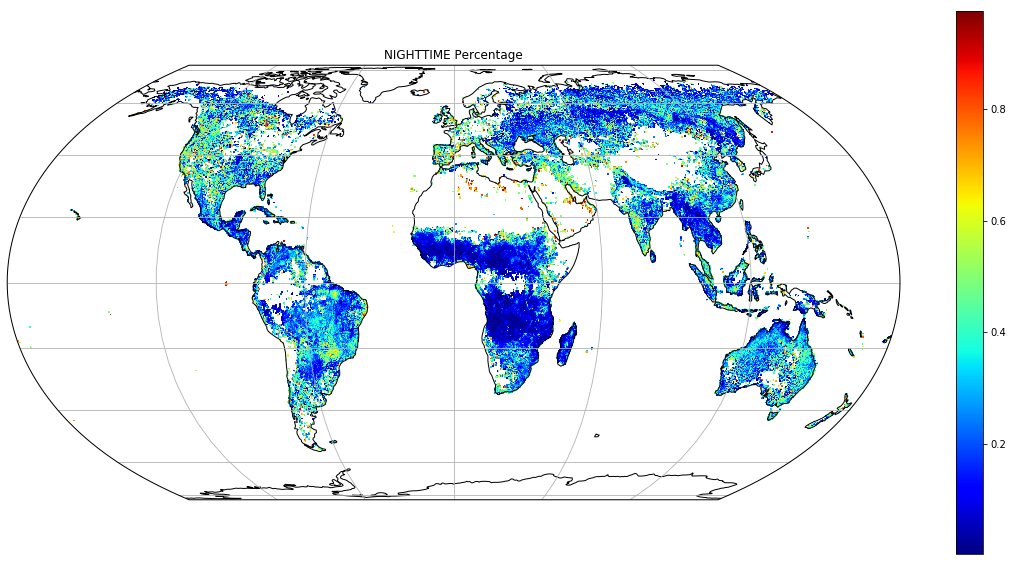

In [9]:
gen_plot_xarr(perc_night_total, raster_folder, title='NIGHTTIME Percentage');

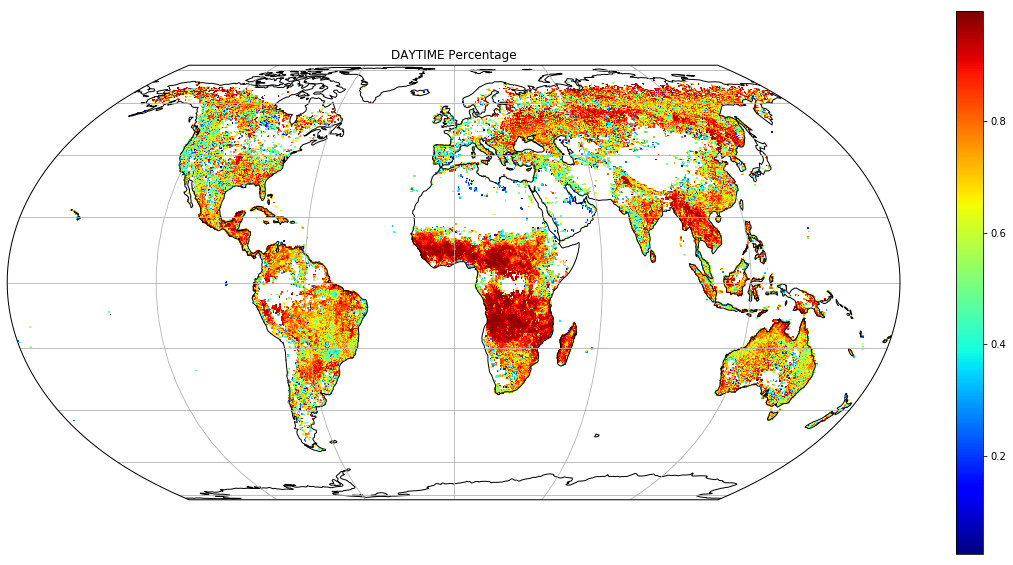

In [10]:
gen_plot_xarr(perc_day_total, raster_folder, title='DAYTIME Percentage');

In [11]:
# fn = r'D:\projects\RD\night_fire\figs\global\perc_night_total.tif'
# write_out(perc_night_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# fn = r'D:\projects\RD\night_fire\figs\global\perc_day_total.tif'
# write_out(perc_day_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# for fixing mis classifications
fn = r'D:\projects\RD\night_fire\figs\global\SOLARELEV_perc_night_total.tif'
write_out(perc_night_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\SOLARELEV_perc_day_total.tif'
write_out(perc_day_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [64]:
folder = '../mcd14ml_solar-elevation-angle/'
csv_files = glob(folder + '*.csv')

day_counts = []
night_counts = []
nperc_ds = []
nct_ds = []
dct_ds = []
for csvfi in csv_files[3:-1]:
    
    year = int(os.path.basename(csvfi).split('_')[-1].split('.')[0])
    print(f'on year {year}')
    
    
    _df = pd.read_csv(csvfi)
    _df = _df.loc[(_df['CONFIDENCE'] > 10) & (_df['TYPE'] == 0)]
    
    #reassign daynight based on solar elevation
    og_day_cts = _df.loc[_df['DAYNIGHT']=='D'].shape[0]
    og_night_cts = _df.loc[_df['DAYNIGHT']=='N'].shape[0]
    
    _df.loc[_df['solar_elev_ang'] < 0, 'DAYNIGHT'] = 'N'
    _df.loc[_df['solar_elev_ang'] > 0, 'DAYNIGHT'] = 'D'
    
    rc_day_cts = _df.loc[_df['DAYNIGHT']=='D'].shape[0]
    rc_night_cts = _df.loc[_df['DAYNIGHT']=='N'].shape[0]
    
#     print(f'# misclassified day: {rc_day_cts - og_day_cts}')
#     print(f'# misclassified night: {rc_night_cts - og_night_cts}')
    
#     print(f'total day cts for {year}: {rc_day_cts}')
#     print(f'total night cts for {year}: {rc_night_cts}')
    
    day_counts.append(rc_day_cts)
    night_counts.append(rc_night_cts)
    
    # group by latitude single degree
    _df['round_lat'] = np.floor(_df['LATITUDE'])
    _day = _df.loc[_df['DAYNIGHT']=='D'].groupby('round_lat').count()
    _night = _df.loc[_df['DAYNIGHT']=='N'].groupby('round_lat').count()
    
    _day_count = _day['FRP']
    _night_count = _night['FRP']
    nperc = _night_count / (_night_count + _day_count)
    nperc_ds.append(nperc)
    nct_ds.append(_night_count)
    dct_ds.append(_day_count)

on year 2003
on year 2004
on year 2005
on year 2006
on year 2007
on year 2008
on year 2009
on year 2010
on year 2011
on year 2012
on year 2013
on year 2014
on year 2015
on year 2016
on year 2017
on year 2018


In [120]:
day_cts_arr = np.array(day_counts)
night_cts_arr = np.array(night_counts)

print(f'total nighttime count percentage: {night_cts_arr.sum() / (night_cts_arr.sum() + day_cts_arr.sum()) *100: .2f}%')
print(f'total nighttime counts: {night_cts_arr.sum()}')
print(f'total daytime counts: {day_cts_arr.sum()}')
print(f'annual average % of nighttime counts: {(night_cts_arr / (night_cts_arr + day_cts_arr)).mean()*100:.2f}%')
print(f'annual std % of nighttime counts: {(night_cts_arr / (night_cts_arr + day_cts_arr)).std()*100:.2f}%')

total nighttime count percentage:  10.42%
total nighttime counts: 7553278
total daytime counts: 64914603
annual average % of nighttime counts: 10.40%
annual std % of nighttime counts: 0.84%


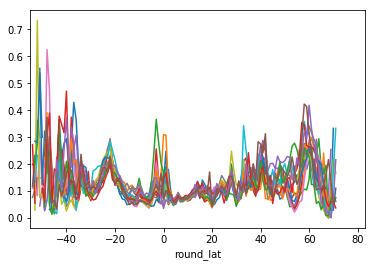

([0.14386933027075632,
  0.11571602194007959,
  0.12796522250340978,
  0.125448917610355,
  0.13177948879494442,
  0.1154529320112294,
  0.12393359532798603,
  0.12585776981245736,
  0.1197823717349228,
  0.13784855935830134,
  0.1229228437409729,
  0.12600914787225773,
  0.12585600360760935,
  0.13371725507028656,
  0.14202395157389924,
  0.13521682757525086],
 0.1283375149252949)

In [65]:
[_.shape for _ in nperc_ds]

fig, ax = plt.subplots()
[_.plot(ax=ax) for _ in nperc_ds]
plt.show()

[_.mean() for _ in nperc_ds], np.mean([_.mean() for _ in nperc_ds])

(<matplotlib.axes._subplots.AxesSubplot at 0x2e0eedcacf8>, 0.1342985888653435)

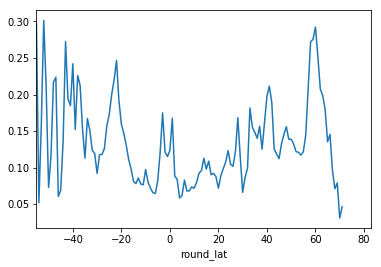

In [72]:
n_df = pd.DataFrame(nct_ds).T.sum(axis=1)
d_df = pd.DataFrame(dct_ds).T.sum(axis=1)
perc_night_cts = n_df.fillna(0) / (n_df.fillna(0) + d_df.fillna(0))

perc_night_cts.plot(), perc_night_cts.mean()

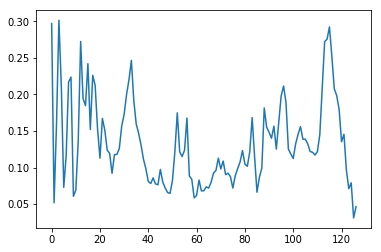

In [73]:
plt.plot(perc_night_cts.values)

In [32]:
perc_night_total.mean()

0.2690683929019884

In [42]:
# group by latitude single degree
_df['round_lat'] = np.floor(_df['LATITUDE'])
_day = _df.loc[_df['DAYNIGHT']=='D'].groupby('round_lat').count()
_night = _df.loc[_df['DAYNIGHT']=='N'].groupby('round_lat').count()

(<matplotlib.axes._subplots.AxesSubplot at 0x2e111ef12e8>, 0.13521682757525086)

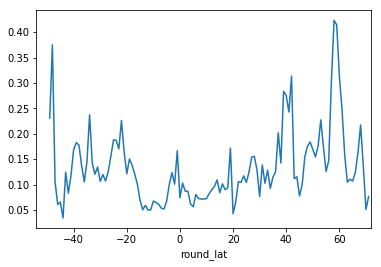

In [45]:
_day_count = _day['FRP']
_night_count = _night['FRP']
nperc = _night_count / (_night_count + _day_count)

nperc.plot(), nperc.mean()

## Plot by Longitude

In [12]:
# to sum by latitude, sum across the columns


In [77]:
day_sum_lat = day_sum.filled(0).sum(axis=1)
night_sum_lat = night_sum.filled(0).sum(axis=1)

day_sum_lat = np.ma.sum(day_sum, axis=1)
night_sum_lat = np.ma.sum(night_sum, axis=1)

# day_sum_lat = np.ma.masked_equal(day_sum_lat, 0)
# night_sum_lat = np.ma.masked_equal(night_sum_lat, 0)
day_sum_lat.shape, type(day_sum_lat)

((721,), numpy.ma.core.MaskedArray)

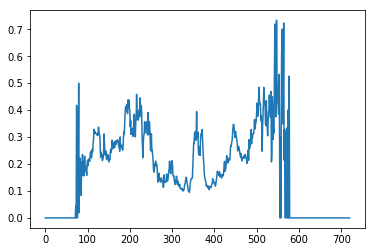

In [78]:
perc_night_lat = night_sum_lat / (night_sum_lat + day_sum_lat)

perc_night_lat = np.ma.MaskedArray(perc_night_lat, mask=np.isnan(perc_night_lat))

plt.plot(perc_night_lat.filled(0))

In [79]:
#plt.plot(np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

In [80]:
tform = op_0_25_prof['transform']
ncols = op_0_25_prof['width']
nrows = op_0_25_prof['height']

In [81]:
lons = np.arange(tform.f , -tform.f + tform.e, tform.e) 
lons.max(), lons.min()

lons=lons[..., np.newaxis]
perc_night_lat=perc_night_lat[...,np.newaxis]

# apply perc_night_lat mask to lons
lons_ma = np.ma.MaskedArray(lons, mask=perc_night_lat.mask[:-1])

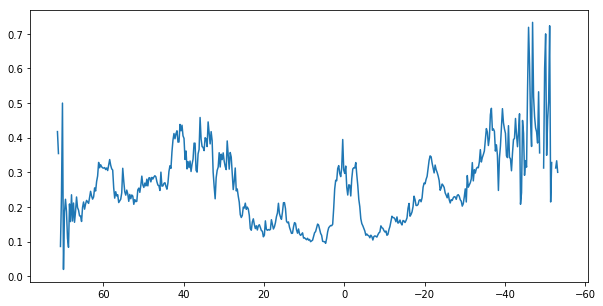

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(lons, perc_night_lat)
ax.plot(lons_ma, perc_night_lat[:-1])
ax.invert_xaxis()
plt.show()

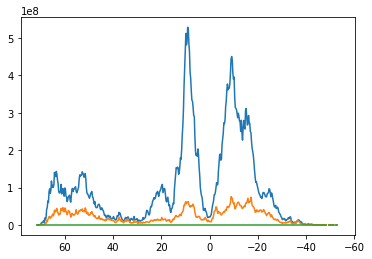

Text(0, 0.5, '% Nighttime Detections')

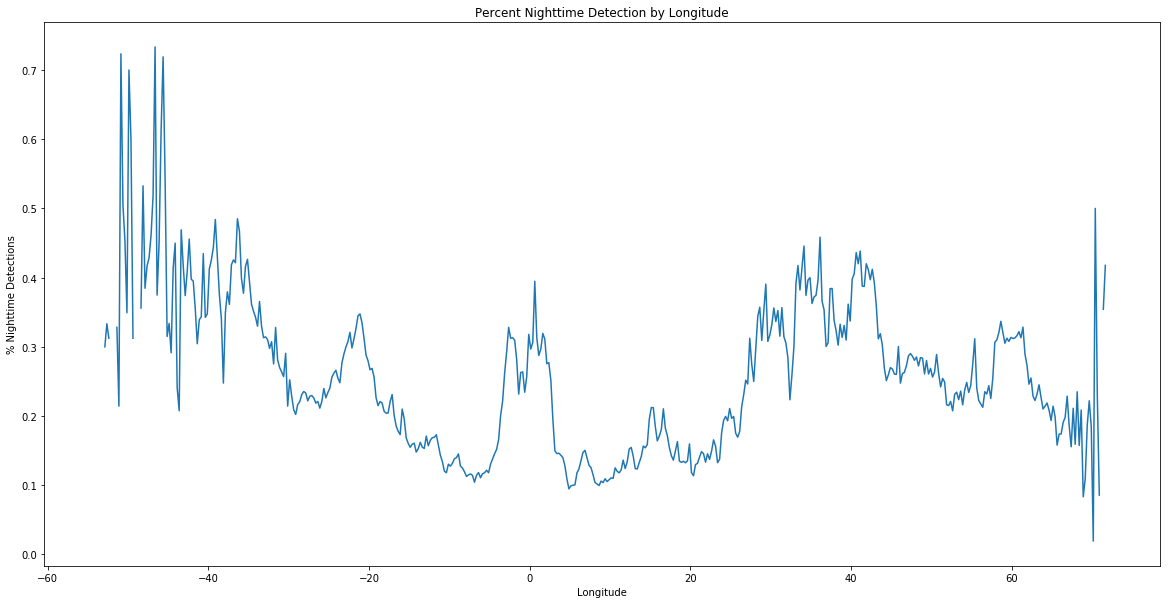

In [83]:
fig, ax = plt.subplots()
ax.plot(lons, day_sum_lat[1:])
ax.plot(lons, night_sum_lat[1:])
night_perc = night_sum_lat / (day_sum_lat + night_sum_lat)
ax.plot(lons, night_perc[1:])
ax.invert_xaxis()
plt.show()


fig, ax = plt.subplots(figsize=(20,10))
night_perc = night_sum_lat / (day_sum_lat + night_sum_lat)
ax.plot(lons, night_perc[1:])
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')

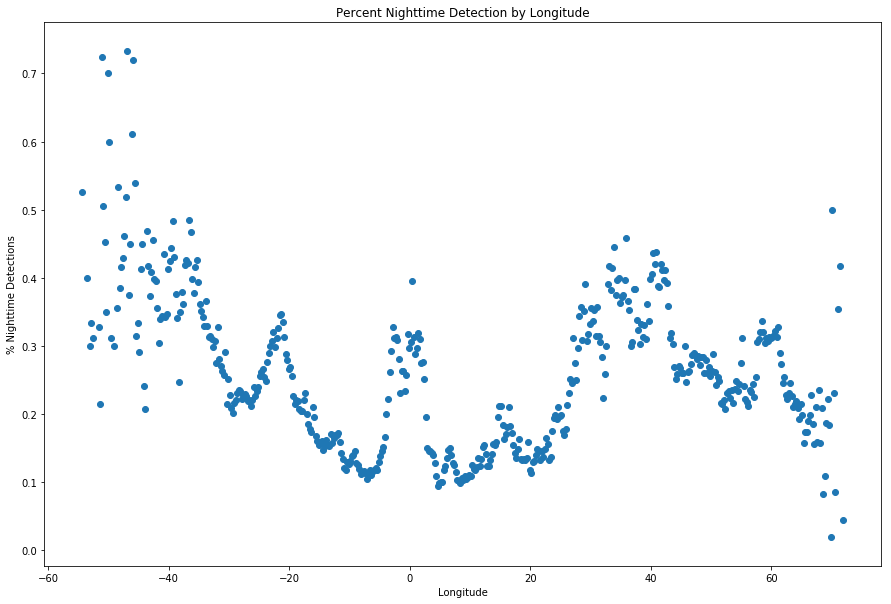

In [84]:
fig, ax = plt.subplots(figsize=(15,10))
# plt.plot(lons, perc_night_lat)
ax.scatter(lons, perc_night_lat[:-1])
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')
plt.show()

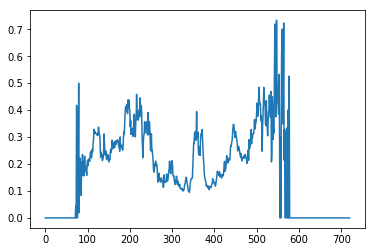

In [85]:
test = night_sum_lat.filled(0) / (night_sum_lat.filled(0) + day_sum_lat.filled(0))
test_ma = np.ma.MaskedArray(test, mask=np.isnan(test))
plt.plot(test_ma.filled(0))

## aggregate

In [86]:
days_fl, nights_fl=[],[]
day_an_agg, night_an_agg = [],[]
agg = 4
for year in range(2003,2019):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*365.25, 0) # annual overpass average
    
    day_arr*=op_oc
    night_arr*=op_oc
    
    arr_list = []
    if agg > 1:
        
        arr_list = []
        for a in day_arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        day_arr = np.array(arr_list)
        
        arr_list = []
        for a in night_arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        night_arr = np.array(arr_list)
    
    day_an_agg.append(day_arr)
    night_an_agg.append(night_arr)
    
    continue

In [87]:
day_sum_agg = np.ma.concatenate(day_an_agg, axis=0).sum(axis=0)
night_sum_agg = np.ma.concatenate(night_an_agg, axis=0).sum(axis=0)
perc_day_total_agg = day_sum_agg / (day_sum_agg + night_sum_agg)
perc_night_total_agg = night_sum_agg / (day_sum_agg + night_sum_agg)

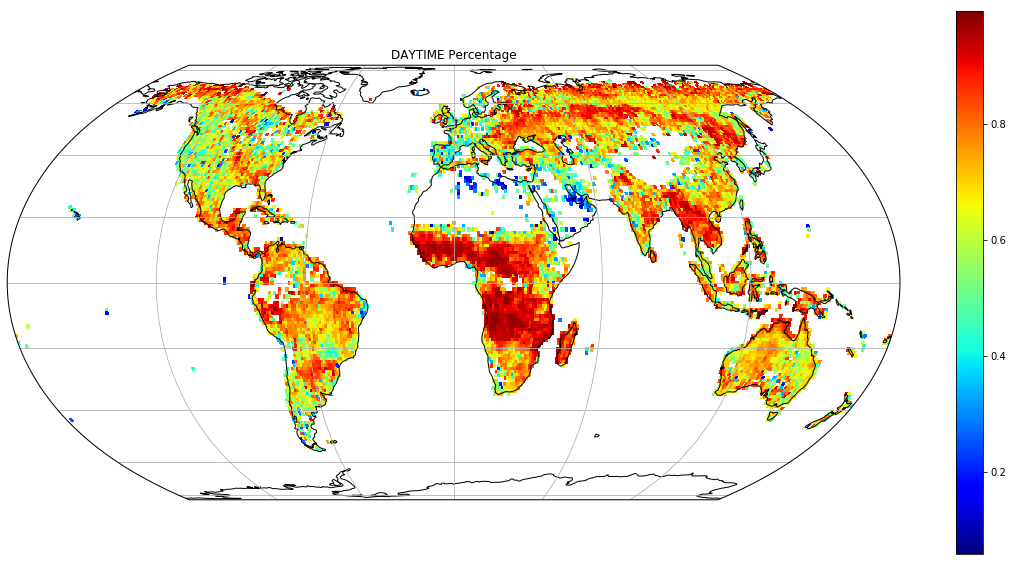

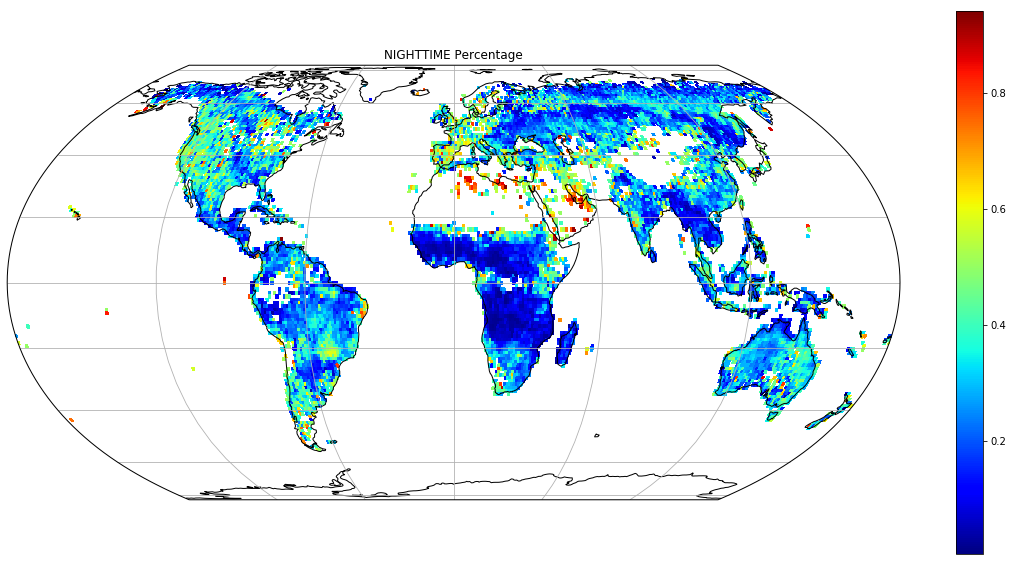

In [88]:
gen_plot_xarr(perc_day_total_agg, raster_folder, title='DAYTIME Percentage', agg=agg);
gen_plot_xarr(perc_night_total_agg, raster_folder, title='NIGHTTIME Percentage', agg=agg);


In [89]:
fn = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_perc_night_total.tif'
write_out_agg(perc_night_total_agg, fn, 'climate_grid_meta_0_25_wgs84.pickle', agg=1.0)

fn = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_perc_day_total.tif'
write_out_agg(perc_day_total_agg, fn, 'climate_grid_meta_0_25_wgs84.pickle', agg=1.0)

## summarize by longitude

In [90]:
day_sum_lat_agg = day_sum_agg.filled(0).sum(axis=1)
night_sum_lat_agg = night_sum_agg.filled(0).sum(axis=1)

# day_sum_lat_agg = np.ma.sum(day_sum_agg, axis=1)
# night_sum_lat_agg = np.ma.sum(night_sum_agg, axis=1)

perc_night_lat_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
perc_night_lat_agg = np.ma.MaskedArray(perc_night_lat_agg, mask=np.isnan(perc_night_lat_agg))

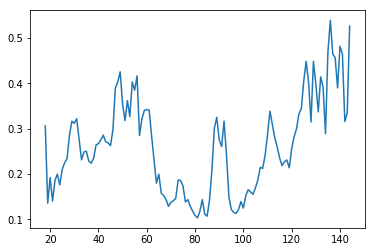

In [91]:
plt.plot(perc_night_lat_agg)

In [92]:
np.ma.mean(perc_night_lat_agg), np.ma.mean(perc_night_lat)

(0.2615009217750369, 0.2590232356902092)

In [93]:
lons_agg = np.arange(tform.f + tform.e*agg , -tform.f+ tform.e*agg, tform.e*agg) 
print(lons_agg.max(), lons_agg.min())

lons_agg=lons_agg[..., np.newaxis]
perc_night_lat_agg=perc_night_lat_agg[...,np.newaxis]

88.875 -90.125


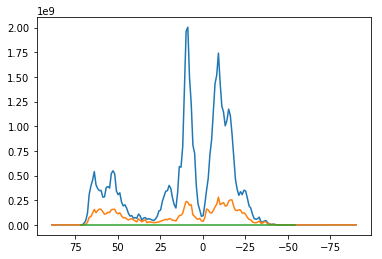

Text(0, 0.5, '% Nighttime Detections')

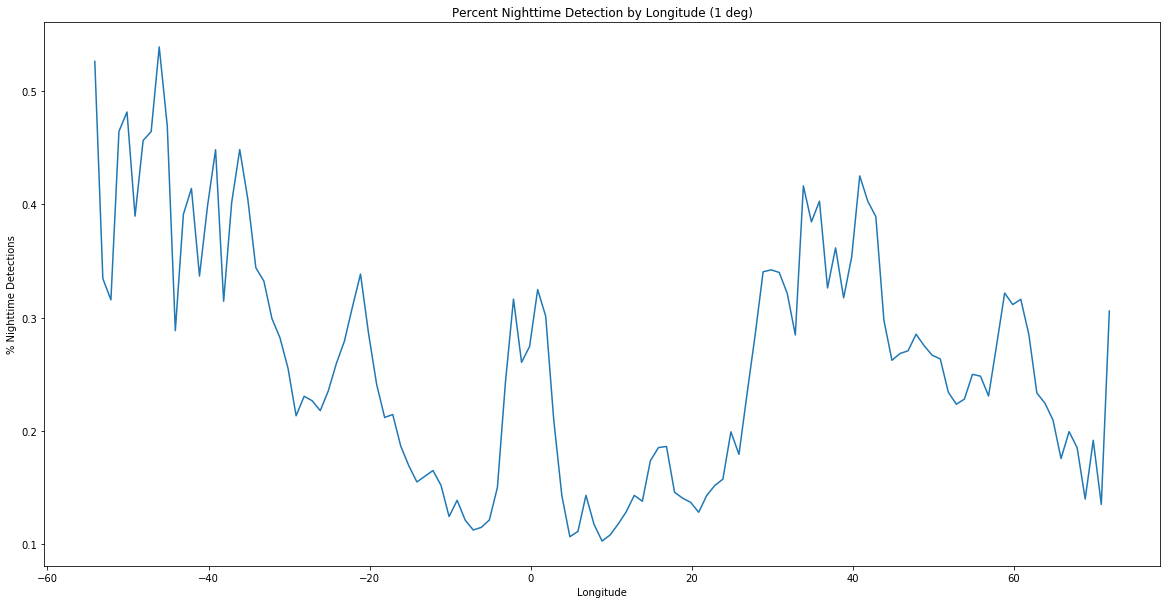

In [94]:
fig, ax = plt.subplots()
ax.plot(lons_agg, day_sum_lat_agg[1:])
ax.plot(lons_agg, night_sum_lat_agg[1:])
night_perc_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
ax.plot(lons_agg, night_perc_agg[1:])
ax.invert_xaxis()
plt.show()


fig, ax = plt.subplots(figsize=(20,10))
night_perc_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
ax.plot(lons_agg, night_perc_agg[1:])
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude (1 deg)')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')

Text(0, 0.5, '% Nighttime Detections')

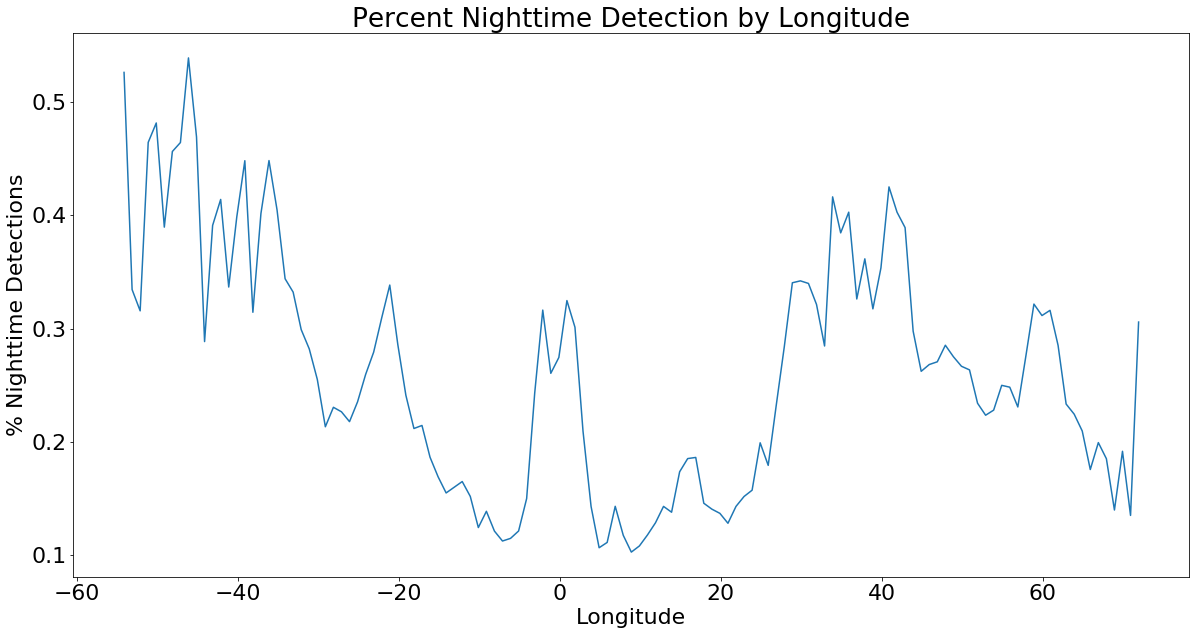

In [95]:
rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 22}

matplotlib.rc('font', **font)

night_perc_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
day_perc_agg = day_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)

d_10 = np.percentile(day_sum_agg, 10, axis=1) 
d_90 = np.percentile(day_sum_agg, 90, axis=1) 
n_10 = np.percentile(night_sum_agg, 10, axis=1) 
n_90 = np.percentile(night_sum_agg, 90, axis=1) 
#print(d_10, d_90, n_10, n_90)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(lons_agg, night_perc_agg[1:], label='Night')
# ax.plot(lons_agg, day_perc_agg[1:], label='Night')
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')

In [96]:
print(agg)

data = perc_night_total_agg
agg_fact=agg
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta

tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = data.shape[1]
num_y = data.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)


# make data into xarray with location
xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
xdata = xr.where(xdata == 0, np.nan, xdata)

4


In [97]:
print(agg)

data = perc_night_total_agg
agg_fact=agg
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta

tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = data.shape[1]
num_y = data.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)


# make data into xarray with location
xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
xdata = xr.where(xdata == 0, np.nan, xdata)

4


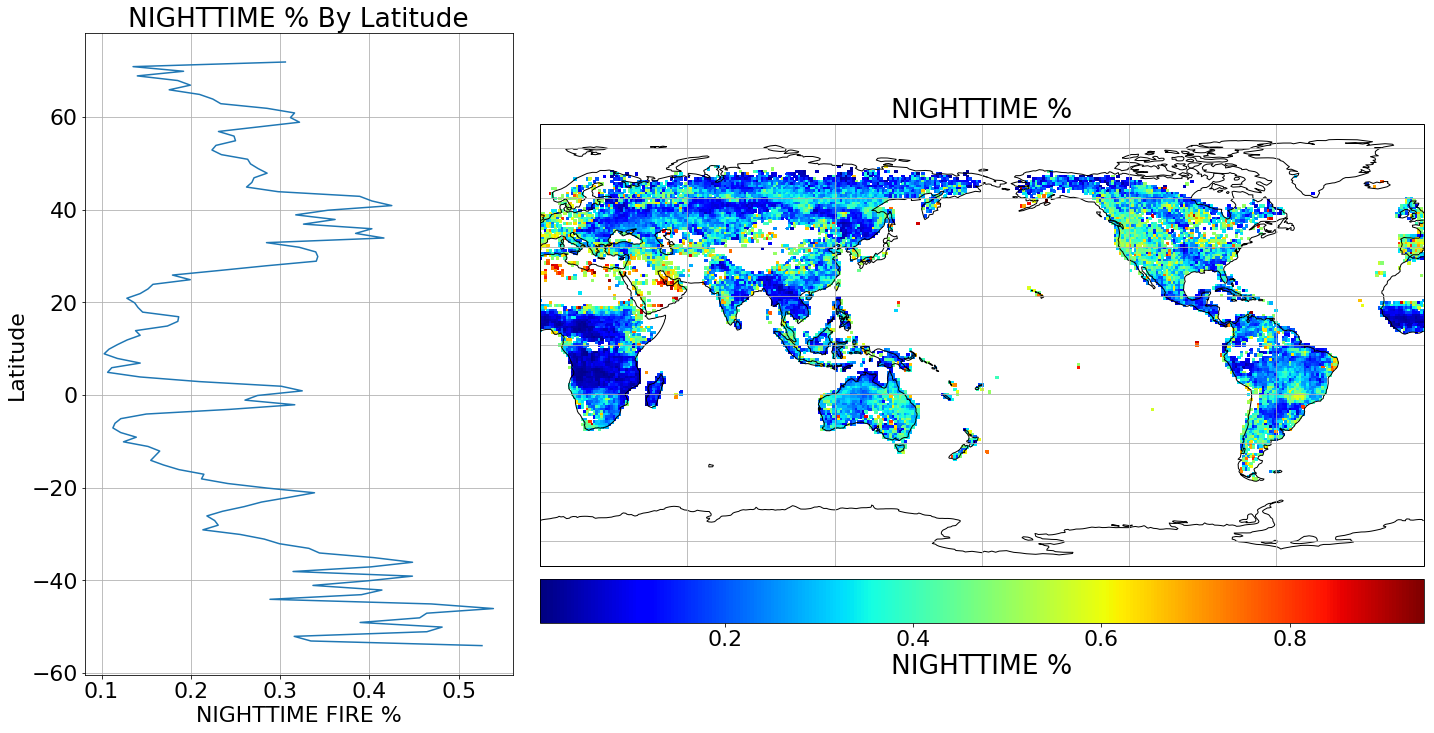

In [98]:
### using subplots
fig = plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(night_perc_agg[1:], lons_agg, label='Night')
plt.grid(True)
plt.tight_layout()
plt.xlabel('NIGHTTIME FIRE %')
plt.ylabel('Latitude')
plt.title('NIGHTTIME % By Latitude')

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
ax = plt.subplot(1,3,(2,3), projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()
ax.coastlines()
ax.gridlines()
cf4 = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', add_colorbar=False)
ax.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('NIGHTTIME %', size='large')

plt.savefig('C:/users/jomc9287/desktop/test.png')
plt.show()

In [99]:
from scipy.signal import spline_filter, medfilt

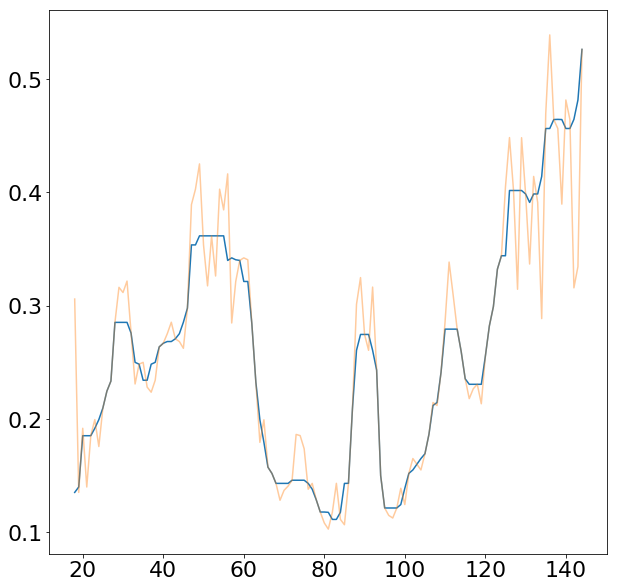

In [100]:
sm_perc = medfilt(perc_night_lat_agg.squeeze(), 7)
sm_perc = np.ma.MaskedArray(sm_perc, mask=perc_night_lat_agg.mask)
plt.plot(sm_perc)
plt.plot(perc_night_lat_agg, alpha=0.4)
plt.show()

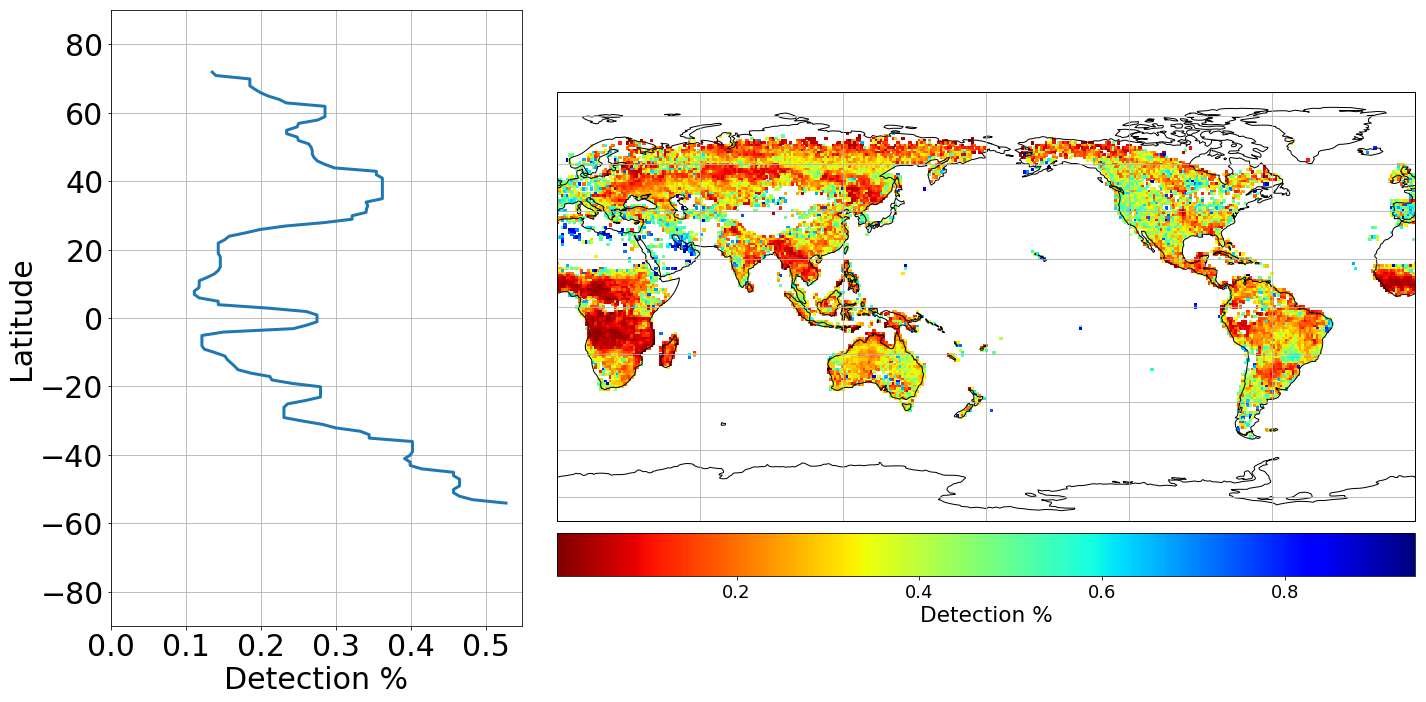

In [104]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 30}

matplotlib.rc('font', **font)

### using subplots
fig = plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(sm_perc[1:], lons_agg, label='Night', linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.ylim(-90,90)
xticks = list(np.arange(0.0,0.6,0.1))
plt.xticks(xticks)
plt.xlabel('Detection %')
plt.ylabel('Latitude')
# plt.title('NIGHTTIME % By Latitude')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
ax = plt.subplot(1,3,(2,3), projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()
ax.coastlines()
ax.gridlines()
cf4 = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet_r', add_colorbar=False)
# ax.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('Detection %', size='large')

plt.savefig('C:/users/jomc9287/desktop/test.png')
plt.show()

## use the point detection data

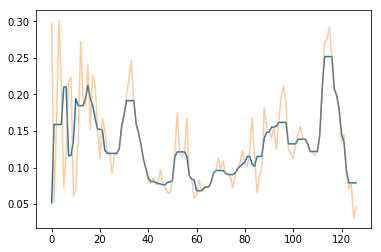

In [76]:
perc_night_cts.values

sm_perc1 = medfilt(perc_night_cts.values, 7)
# sm_per1c = np.ma.MaskedArray(sm_perc1, mask=perc_night_lat_agg.mask)
plt.plot(sm_perc1)
plt.plot(perc_night_cts.values, alpha=0.4)
plt.show()

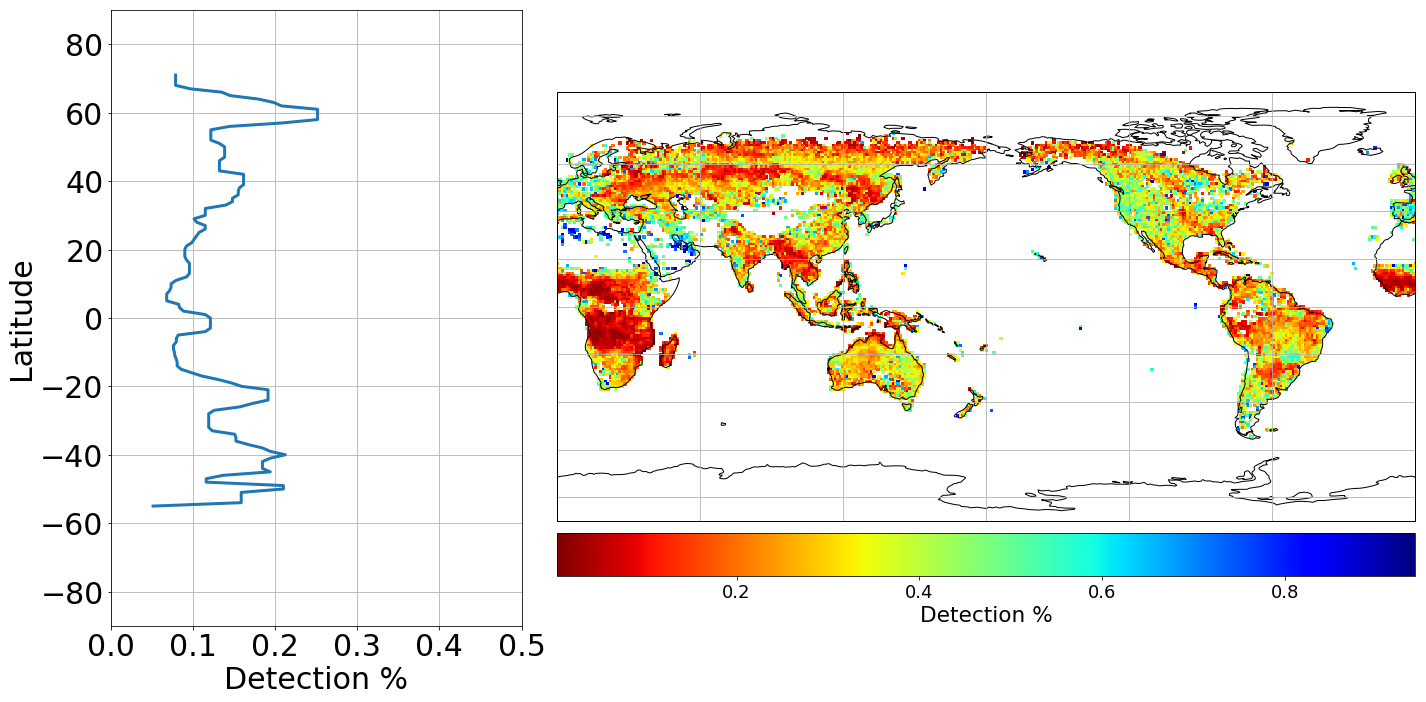

In [103]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 30}

matplotlib.rc('font', **font)

### using subplots
fig = plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(sm_perc1, perc_night_cts.index.values, label='Night', linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.ylim(-90,90)
xticks = list(np.arange(0.0,0.6,0.1))
plt.xticks(xticks)
plt.xlabel('Detection %')
plt.ylabel('Latitude')
# plt.title('NIGHTTIME % By Latitude')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
ax = plt.subplot(1,3,(2,3), projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()
ax.coastlines()
ax.gridlines()
cf4 = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet_r', add_colorbar=False)
# ax.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('Detection %', size='large')

plt.savefig('C:/users/jomc9287/desktop/test_pts.png')
plt.show()

### how different are they?

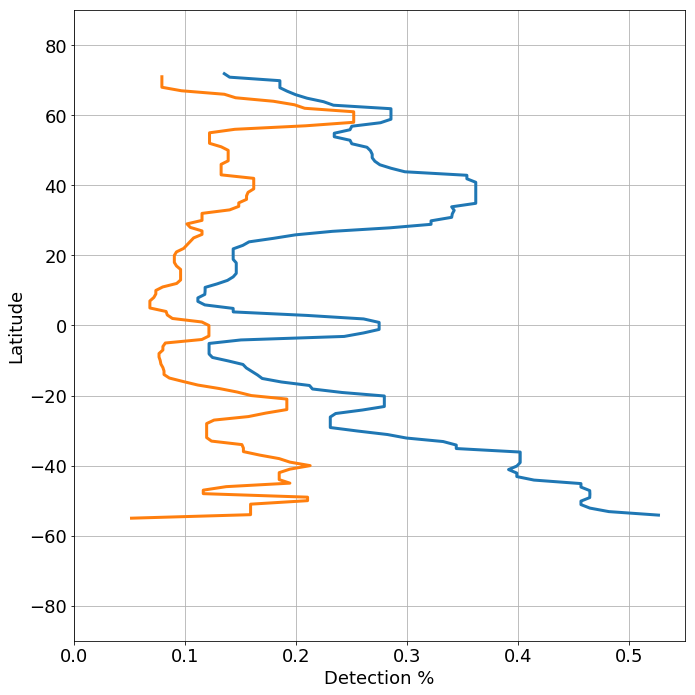

In [105]:
plt.plot(sm_perc[1:], lons_agg, label='Night', linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.ylim(-90,90)
xticks = list(np.arange(0.0,0.6,0.1))
plt.xticks(xticks)
plt.xlabel('Detection %')
plt.ylabel('Latitude')

plt.plot(sm_perc1, perc_night_cts.index.values, label='Night', linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.ylim(-90,90)
xticks = list(np.arange(0.0,0.6,0.1))
plt.xticks(xticks)
plt.xlabel('Detection %')
plt.ylabel('Latitude')

plt.show()

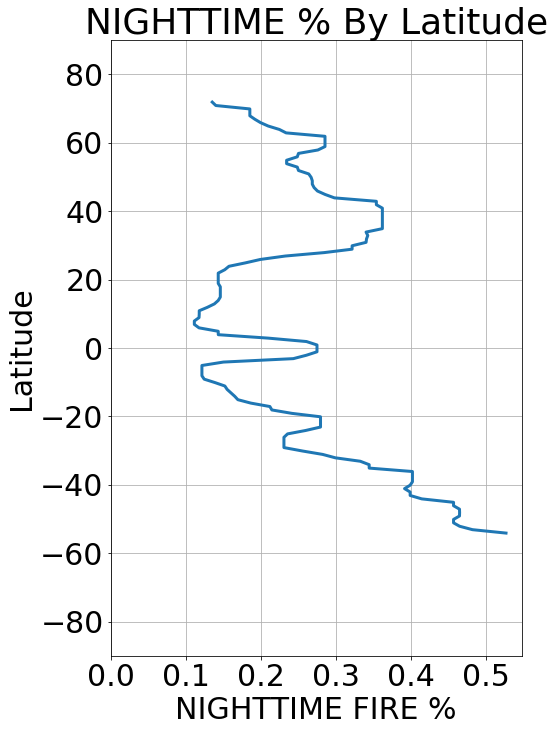

In [186]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 30}

matplotlib.rc('font', **font)

### using subplots
fig = plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(sm_perc[1:], lons_agg, label='Night', linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.ylim(-90,90)
xticks = list(np.arange(0.0,0.6,0.1))
plt.xticks(xticks)
plt.xlabel('NIGHTTIME FIRE %')
plt.ylabel('Latitude')
plt.title('NIGHTTIME % By Latitude')

plt.savefig('C:/users/jomc9287/desktop/perc_night_lat_plot.png')
plt.show()

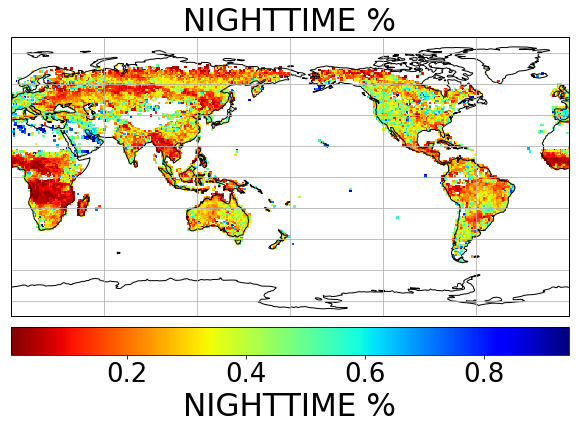

In [184]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 26}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
ax = plt.subplot(1,3,(2,3), projection=ccrs.PlateCarree(central_longitude=180))
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()
ax.coastlines()
ax.gridlines()
cf4 = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet_r', add_colorbar=False)
ax.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('NIGHTTIME %', size='large')

plt.savefig('C:/users/jomc9287/desktop/per_night_map.png')
plt.show()

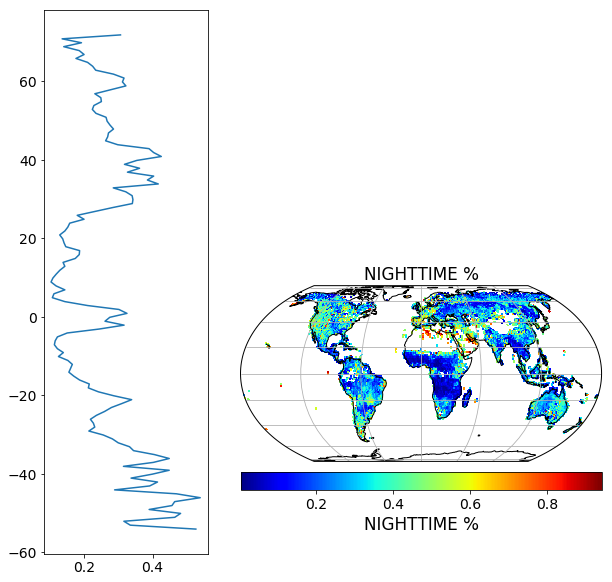

In [116]:
# Make sure that the subplots don't initially overlap:                                                                                         
g = plt.GridSpec(1, 3)


# Use position/dimensions of the first subplot's bbox to resize the second subplot:                                                            
ax2 = plt.subplot(g[0, 1:], projection=ccrs.EqualEarth())
ax2.set_global()
ax2.coastlines()
ax2.gridlines()
cf4 = xdata.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='jet', add_colorbar=False)
ax2.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax2, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('NIGHTTIME %', size='large')
box2 = ax2.get_position()

# First subplot:                                                                                                                               
ax1 = plt.subplot(g[0, 0])
plt.plot(night_perc_agg[1:], lons_agg, label='Night')
box1 = ax1.get_position()
# ax1.set_position([box2.x0, box2.y0,
#                  (b0x1.x1 -)])


# plt.plot(x2, y2)
# box2 = ax2.get_position()
# ax2.set_position([box2.x0, box2.y0,
#                   (box1.x1-box1.x0)*max2/max1, box1.y1-box1.y0])


plt.show()

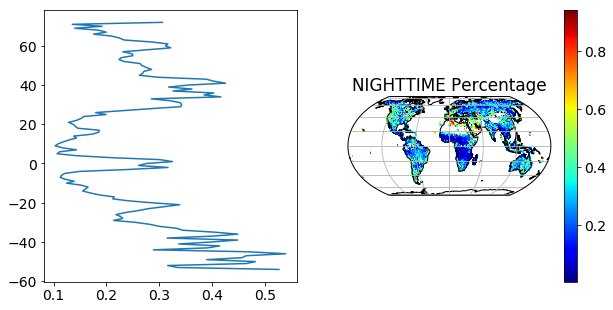

In [83]:
### this kind of works

# fig, ax = plt.subplots(1,2, figsize=(10,10))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)

# create and plot the summary latitude data on first axis
x_data_lat = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
xdata_lat = xr.DataArray(x_data_lat, coords=[tlat], dims=['lat'])
# xdata_lat.plot(ax=ax1)
ax1.plot(night_perc_agg[1:], lons_agg, label='Night')

# plot the map data on second axis
ax2 = fig.add_subplot(122,projection=ccrs.EqualEarth())
ax2.set_global()
ax2.coastlines()
ax2.gridlines()
xdata.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='jet', add_colorbar=True)
ax2.set_title('NIGHTTIME Percentage')


# plt.savefig('C:/users/jomc9287/desktop/test.png')
plt.show()

('lat',)

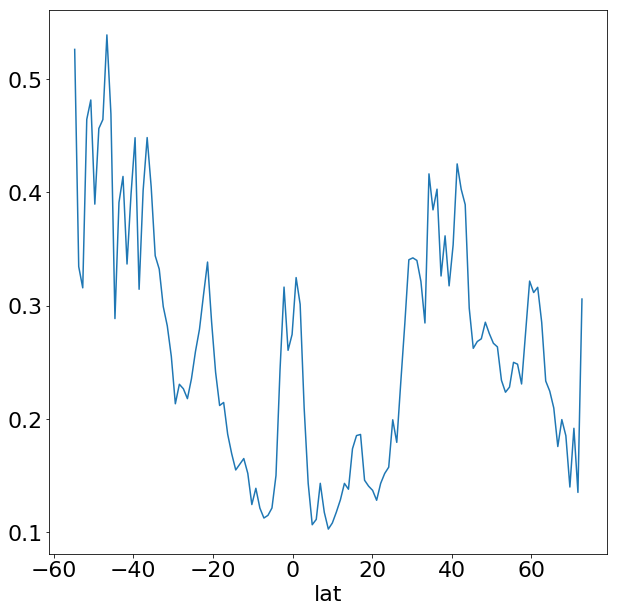

In [67]:
xdata.reduce(np.ma.sum, dim='lat').shape
xdata.reduce(np.nansum, dim='lat').values
# xdata.dims

x_data_lat = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
xdata_lat = xr.DataArray(x_data_lat, coords=[tlat], dims=['lat'])
xdata_lat.plot()

xdata_lat.dims

# Overpass corrected
### write out the nighttime data

In [89]:
if not os.path.exists(r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg'):
    os.makedirs(r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg')
    
# write out all nighttime rasters
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_pvals_fireyear.tif'
write_out(np.where(p_arr != 1, p_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_slope_pos_fireyear.tif'
write_out(np.where(s_arr > 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_slope_neg_fireyear.tif'
write_out(np.where(s_arr < 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_numyears_fireyear.tif'
write_out(n_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_night_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')


In [90]:
# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_night_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_night_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_night_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_night_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

### write out the nighttime data

In [ ]:
# write out all nighttime rasters
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_pvals_fireyear.tif'
write_out(np.where(p_arr != 1, p_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_slope_pos_fireyear.tif'
write_out(np.where(s_arr > 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_slope_neg_fireyear.tif'
write_out(np.where(s_arr < 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_numyears_fireyear.tif'
write_out(n_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_night_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')


In [ ]:
# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_night_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_night_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_night_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_night_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

### do the same for daytime data

In [92]:
s_d,i_d,r_d,p_d,ste_d, n_d = [],[],[],[],[],[]
x = np.arange(day_arr.shape[0])
y_arr = np.rollaxis(test_day,0,3)
y_arr = np.reshape(y_arr, (test_day.shape[1]*test_day.shape[2], test_day.shape[0]))
for y in y_arr:
    _s, _i, _r, _p, _ste = linregress(x,y)
    #_n = ~np.isnan(y).sum()
    _n = (y>0).sum()
    
    s_d.append(_s)
    i_d.append(_i)
    r_d.append(_r)
    p_d.append(_p)
    ste_d.append(_ste)
    n_d.append(_n)

In [93]:
sd_arr = np.array(s_d).reshape(day_arr.shape[1:])
pd_arr = np.array(p_d).reshape(day_arr.shape[1:])
nd_arr = np.array(n_d).reshape(day_arr.shape[1:])

In [94]:
if not os.path.exists(r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg'):
    os.makedirs(r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg')
    

In [97]:
# write out all nighttime rasters
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_pvals_day_fireyear.tif'
write_out(np.where(pd_arr != 1, pd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_slope_pos_fireyear.tif'
write_out(np.where(sd_arr > 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_slope_neg_fireyear.tif'
write_out(np.where(sd_arr < 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_numyears_fireyear.tif'
write_out(nd_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\all_day_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [98]:
# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_day_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_day_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_day_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\overpass_corrected_agg\BIN_all_day_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [ ]:
# write out all nighttime rasters
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_pvals_day_fireyear.tif'
write_out(np.where(pd_arr != 1, pd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_slope_pos_fireyear.tif'
write_out(np.where(sd_arr > 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_slope_neg_fireyear.tif'
write_out(np.where(sd_arr < 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_numyears_fireyear.tif'
write_out(nd_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\all_day_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [ ]:
# write out slopes where p < 0.05
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_day_slope_pos_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_day_slope_neg_PVAL0_05_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_day_slope_pos_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\BIN_all_day_slope_neg_PVAL0_1_fireyear.tif'
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [ ]:
day_title = 'day fire season length slope > 0'
gen_plot_xarr(sd_arr, raster_folder, day_title, cmap='Spectral_r');
gen_plot_xarr(np.where(np.abs(sd_arr) >=0.01, sd_arr, np.nan), raster_folder, day_title, cmap='Spectral_r');
gen_plot_xarr(np.where(pd_arr != 1, pd_arr, np.nan), raster_folder, "p-values", cmap='Spectral_r');
gen_plot_xarr(nd_arr, raster_folder, "number of data points", cmap='Spectral_r');

In [ ]:
(sd_arr - s_arr).sum()

In [ ]:
night_title = 'night fire season length slope > 0'
gen_plot_xarr(s_arr, raster_folder, night_title, cmap='Spectral_r');
gen_plot_xarr(np.where(np.abs(s_arr) >=0.01, s_arr, np.nan), raster_folder, night_title, cmap='Spectral_r');
gen_plot_xarr(np.where(p_arr != 1, p_arr, np.nan), raster_folder, "p-values", cmap='Spectral_r');
gen_plot_xarr(n_arr, raster_folder, "number of data points", cmap='Spectral_r');

In [ ]:
np.abs(n_arr - nd_arr).sum()

In [ ]:
# np.apply_along_axis(linregress, 0, np.arange(day_arr.shape[0]), y=day_arr)
temp = np.apply_along_axis(linregress, 0, day_arr, y=np.arange(day_arr.shape[0]))

In [ ]:
s_day, i_day, r_day, p_day, stderr_day = temp

In [ ]:
gen_plot_xarr(np.where((p_day < 0.05) & (s_day > 0), p_day, np.nan), raster_folder, night_title, cmap='Spectral_r')

In [ ]:
night_arr = np.array(nights_fl)
temp_n = np.apply_along_axis(linregress, 0, night_arr, y=np.arange(night_arr.shape[0]))

In [ ]:
s_night, i_night, r_night, p_night, stderr_night = temp_n

In [ ]:
gen_plot_xarr(np.where((p_night < 0.05) & (s_night > 0), p_night, np.nan), raster_folder, night_title, cmap='Spectral_r')

In [ ]:
ex_x = np.arange(night_arr.shape[0])
ex_x = ex_x[np.newaxis, np.newaxis, :]


In [ ]:
temp_n = np.apply_along_axis(linregress, 0, ex_x, y=night_arr)

In [ ]:
n=10
_,_,_,_=plot_regress_var(np.array(days_fl), np.array(nights_fl),
                 raster_folder, af_var='AFC_num', reg_month='FIRE SEASON LENGTH', reg_var='slope', n_obsv=n, agg_fact=1,
                    absmin=-.06, # was 3000 un normalized
                    absmax=.06,
                    cm='coolwarm',
                    save=False,
                    save_dir="",
                    cartoplot=True,
                    norm=True,
                    min_year=None)

In [ ]:
n=10
plot_regress_var(np.array(days_fl), np.array(nights_fl),
                 raster_folder, af_var='AFC_num', reg_month='FIRE SEASON LENGTH', reg_var='slope', n_obsv=n, agg_fact=1,
                    absmin=-0.75, # was 3000 un normalized
                    absmax=0.75,
                    cm='coolwarm',
                    save=False,
                    save_dir="",
                    cartoplot=True,
                    norm=False,
                    min_year=None)

## check the overpass estimate raster

In [ ]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 0

with rio.open('../vars/aqua-terra-overpasses-per-day_2.5-degree-grid.tif') as src:
    op_0_2_5 = src.read()[0]
    print(src.profile)
    
    op_0_2_5[op_0_2_5<=0] = 0
    

plt.figure(figsize=(10,5))
plt.imshow(op_0_25)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(op_0_2_5)
plt.colorbar()
plt.show()


In [ ]:
n=10
dson_slope, nson_slope, nd_slope_ratio, nd_slope_dif= plot_regress_var(np.array(days_fl), np.array(nights_fl),
                                                                         raster_folder, af_var='AFC_num', reg_month='SUM', reg_var='slope', n_obsv=n, agg_fact=1,
                                                                            absmin=-0.03, # was 3000 un normalized
                                                                            absmax=0.01,
                                                                            cm='gnuplot',
                                                                            save=False,
                                                                            save_dir="",
                                                                            cartoplot=True,
                                                                            norm=True,
                                                                            min_year=None)

In [ ]:
night_slope_sign = np.sign(nson_slope)
day_slope_sign = np.sign(dson_slope)

night_slope_pos = np.where(night_slope_sign > 0, nson_slope, np.nan)

# plot it
_ = gen_plot_xarr(night_slope_pos, raster_folder, title='Where Night Time Slope Across Fire Years 2003-2018 is Positive\n \
                  Active Fire Counts Summed Across Each Fire Year (overpass corrected)', cmap='coolwarm');

In [ ]:
night_slope_sign = np.sign(nson_slope)
day_slope_sign = np.sign(dson_slope)

night_slope_pos = np.where(night_slope_sign > 0, nson_slope, np.nan)
day_slope_pos = np.where(day_slope_sign > 0, dson_slope, np.nan)

night_slope_neg = np.where(night_slope_sign < 0, nson_slope, np.nan)
day_slope_neg = np.where(day_slope_sign < 0, dson_slope, np.nan)

# plot it
_ = gen_plot_xarr(night_slope_pos, raster_folder, title='Where Night Time Slope Across Fire Years 2003-2018 is Positive\n \
                  Active Fire Counts Summed Across Each Fire Year (not overpass corrected)');

# plot it
_ = gen_plot_xarr(night_slope_pos, raster_folder, title='Where DAY Time Slope Across Fire Years 2003-2018 is Positive\n \
                  Active Fire Counts Summed Across Each Fire Year (not overpass corrected)');

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = night_slope_pos[~np.isnan(night_slope_pos)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with positive NIGHT time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = day_slope_pos[~np.isnan(day_slope_pos)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with positive DAY time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = day_slope_neg[~np.isnan(day_slope_neg)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with negative DAY time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = night_slope_neg[~np.isnan(night_slope_neg)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with negative NIGHT time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# compare histograms
plt.figure(figsize=(20,10))
plt.hist(night_slope_pos.ravel(), bins=100, alpha=0.2, edgecolor='k', label='FY Length Trend Positive')
plt.legend(fontsize=13)
plt.xlabel('Normalized Slope', fontsize=13)
plt.ylabel('# 0.25 Deg Pixels', fontsize=13)
plt.show()

In [13]:
day_files
with rio.open(day_files[3]) as src:
    tform = src.profile['transform']

In [ ]:
num_x = night_slope_neg.shape[1]
num_y = night_slope_neg.shape[0]
# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a, tform.c+num_x*tform.a, num_x)
tlat = np.linspace(tform.f - tform.e, tform.f+num_y*tform.e, num_y)

dplot = night_slope_neg*0+1
nplot = night_slope_pos*0+1

x_dplot = xr.DataArray(dplot, coords=[tlat, tlon], dims=['lat', 'lon'])
x_nplot = xr.DataArray(nplot, coords=[tlat, tlon], dims=['lat', 'lon'])

fig,ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
# ax.gridlines()
x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=1, cmap='coolwarm', add_colorbar=False) # blue
x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm_r',add_colorbar=False)    # red

# ax.imshow(nplot, alpha=1., cmap='coolwarm') # blue, night
# ax.imshow(dplot, alpha=0.25, cmap='coolwarm_r') # red, day
plt.title('Where NIGHT slope is positive (blue) and negative (red)')
plt.show()

In [ ]:
num_x = night_slope_neg.shape[1]
num_y = night_slope_neg.shape[0]
# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a, tform.c+num_x*tform.a, num_x)
tlat = np.linspace(tform.f - tform.e, tform.f+num_y*tform.e, num_y)

dplot = day_slope_neg*0+1
nplot = day_slope_pos*0+1

x_dplot = xr.DataArray(dplot, coords=[tlat, tlon], dims=['lat', 'lon'])
x_nplot = xr.DataArray(nplot, coords=[tlat, tlon], dims=['lat', 'lon'])

fig,ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
# ax.gridlines()

x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm',add_colorbar=False)    # blue
x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm_r', add_colorbar=False) # red


# ax.imshow(nplot, alpha=1., cmap='coolwarm') # blue, night
# ax.imshow(dplot, alpha=0.25, cmap='coolwarm_r') # red, day
plt.title('Where DAY slope is positive (blue) and negative (red)')
plt.show()

In [ ]:
# where night and day slope is positive


num_x = night_slope_neg.shape[1]
num_y = night_slope_neg.shape[0]
# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a, tform.c+num_x*tform.a, num_x)
tlat = np.linspace(tform.f - tform.e, tform.f+num_y*tform.e, num_y)

dplot = day_slope_pos*0+1
nplot = night_slope_pos*0+1

x_dplot = xr.DataArray(dplot, coords=[tlat, tlon], dims=['lat', 'lon'])
x_nplot = xr.DataArray(nplot, coords=[tlat, tlon], dims=['lat', 'lon'])

fig,ax = plt.subplots(figsize=(20,18))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
# ax.gridlines()
# x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.15, cmap='autumn', add_colorbar=False)
# x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.15, cmap='winter',add_colorbar=False)

# night positive
x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.3, cmap='coolwarm', add_colorbar=False) # blue

# day positive
x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm_r',add_colorbar=False)    # red

# ax.imshow(nplot, alpha=1., cmap='coolwarm') # blue, night
# ax.imshow(dplot, alpha=0.25, cmap='coolwarm_r') # red, day
plt.title('Where NIGHT slope is positive (blue) and DAY slope is positive (red)')
plt.show()

In [ ]:
# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        


In [ ]:
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\day_slope_pos_fireyear.tif'
write_out(day_slope_pos*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\day_slope_neg_fireyear.tif'
write_out(day_slope_neg*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\night_slope_pos_fireyear.tif'
write_out(night_slope_pos*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\night_slope_neg_fireyear.tif'
write_out(night_slope_neg*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [ ]:
print('day\tnight')
print(np.nansum(day_slope_pos*0+1), np.nansum(night_slope_pos*0+1))
print(np.nansum(day_slope_neg*0+1), np.nansum(night_slope_neg*0+1))
print(np.nansum(dson_slope*0+1), np.nansum(nson_slope*0+1))

## using regionmask for data masking (test stuff)

In [ ]:
import regionmask
import xshape
import geopandas as gpd
import xarray as xr

In [4]:
conus = gpd.read_file('../CONUS_boundary/CONUS_boundary.shp')
conus.plot()


NameError: name 'gpd' is not defined

In [ ]:
conus_wgs84 = conus.to_crs(epsg=4326)

In [ ]:
# try to use regionmask to clip xarray
day_files, night_files = get_fire_year_files(raster_folder.replace('2_5', '0_25'), var, 2010)
data = xr.open_rasterio(day_files[1])
data

In [ ]:
# construct the region object
numbers = conus_wgs84.index
names = [str(i) for i in conus_wgs84.OBJECTID]
abbrevs = [str(i) for i in conus_wgs84.OBJECTID]
geoms = list(conus_wgs84.geometry)
rmask = regionmask.Regions_cls('USmask', numbers, names, abbrevs, geoms)

# construct the mask, matching spatial coordinate dimensions
data_mask = rmask.mask(data, lon_name='x', lat_name='y')

# mask the data, as well as nodata
nodata=-32768
masked_data = data.where(data_mask>=0)
masked_data = masked_data.where(masked_data!=nodata)
masked_data.plot(figsize=(20,10))
masked_data.min(), masked_data.max()